# KoBERT 모델을 통한 업종 추천 정확도 테스트

1. **train_data**.xlsx: 국세청 11차 표준산업분류 업종명에 대한 학습 키워드
*************************
2. **test_data.xlsx**: 소상공인시장진흥공단_상가(상권)정보 데이터에서 확보한 테스트 키워드
* 다른 테스트 데이터가 있을 경우, 해당 데이터로 코드 상에서 적용 가능
*************************
3. **KoBERT_model.bin**: 'kykim/bert-kor-base' 사전 학습(pre-trained) 모델을 사용해 train_data.xlsx을 학습시킨 모델 (bin 형식의 파일)

**코드 실행할 시, Jupyter Notebook 혹은 Google Colab 사용 권장**

# 라이브러리 세팅 및 데이터 로드

In [1]:
# 라이브러리 임포트
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel, AdamW
from transformers import EncoderDecoderModel
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

# 랜덤 시드 설정 (재현성을 위해)
import random
import numpy as np
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

**Jupyter Notebook으로 데이터 로드**: Jupyter 실행 후 불러올 데이터와 사전 학습된 모델을 옮겨놓는다.



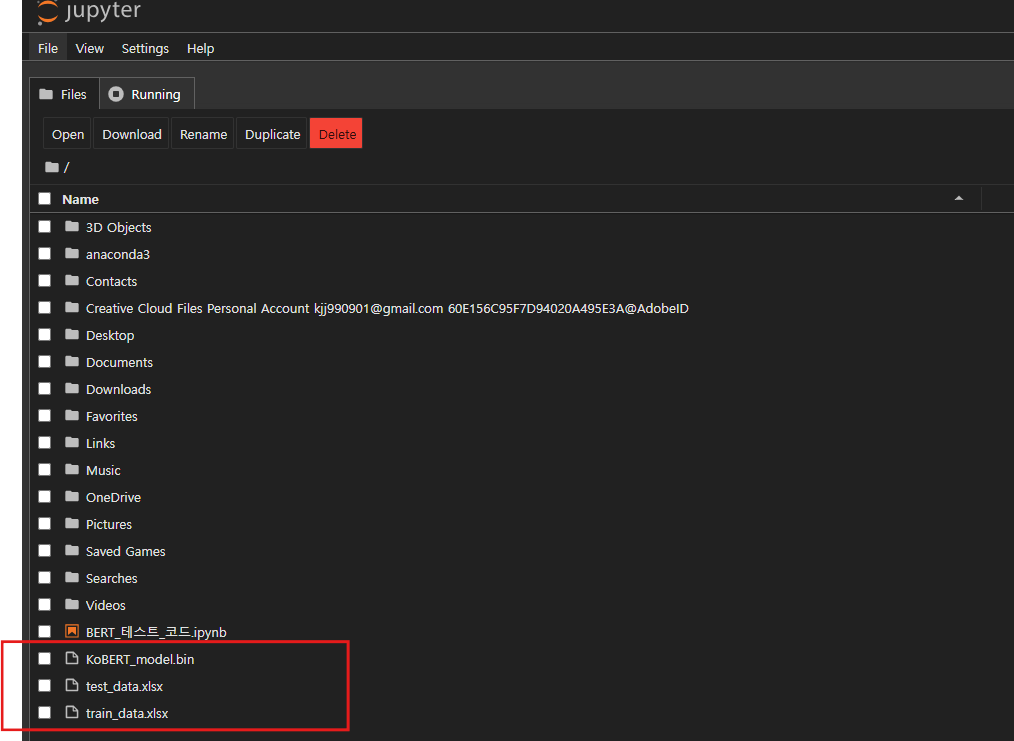

**Google Colab으로 학습, 테스트 데이터 로드**: 아래 코드 실행 -> '파일 선택' 버튼 클릭 후, pc 상에서 데이터 로드

**사전 학습된 모델 (KoBERT_model.bin)**의 경우, 왼쪽의 파일 이모티콘 클릭 후 모델 파일을 드래그해서 업로드

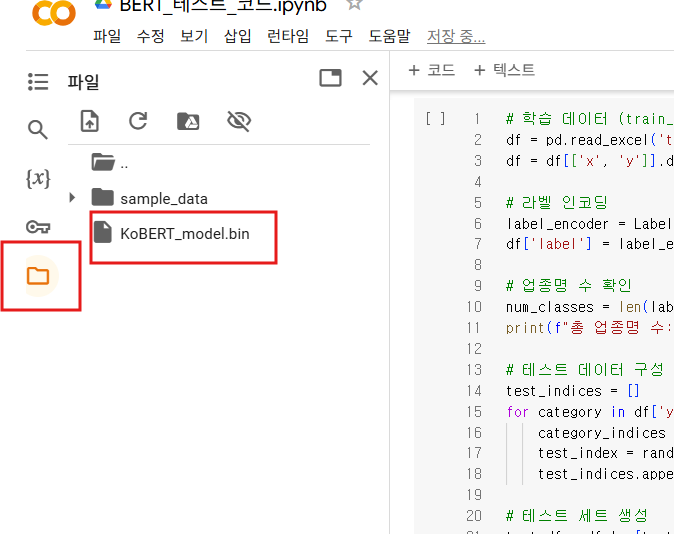

In [2]:
# Colab에서 학습 데이터 로드할 때만, 이 코드 사용
# Jupyter 사용 시, 실행 X
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name = fn, length = len(uploaded[fn])))

Saving train_data.xlsx to train_data.xlsx
User uploaded file "train_data.xlsx" with length 247318 bytes


In [3]:
# 데이터 로드
df = pd.read_excel('train_data.xlsx')
df = df[['x', 'y']].dropna()

# 라벨 인코딩
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['y'])

# 업종명 수 확인
num_classes = len(label_encoder.classes_)
print(f"총 업종명 수: {num_classes}")

# 전체 데이터를 학습 데이터로 사용
train_df = df.copy()

# 확인
print(f"학습 데이터 크기: {len(train_df)}")

총 업종명 수: 1205
학습 데이터 크기: 11011


# BERT 모델 로드 및 세팅

In [4]:
# Subset 객체가 아닌 DataFrame 전체에서 데이터 추출
train_texts = train_df['x'].tolist()
train_labels = train_df['label'].tolist()

# 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base')
bert_model = BertModel.from_pretrained('kykim/bert-kor-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [5]:
# PyTorch Dataset 정의
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=32):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 데이터셋 및 데이터로더 생성
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [6]:
# BERT 기반 분류 모델 정의
class BertClassifier(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 출력
        cls_output = self.dropout(cls_output)
        logits = self.linear(cls_output)
        return logits

# 모델 초기화
bert_classifier = BertClassifier(bert_model, num_classes)

# 디바이스 설정 (GPU 사용 가능 여부)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_classifier = bert_classifier.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(bert_classifier.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
# 학습된 모델 (KoBERT_model.bin) 로드
bert_classifier.load_state_dict(torch.load('KoBERT_model.bin', map_location=torch.device('cpu')))

<ipython-input-8-5bd44fe2b08d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_classifier.load_state_dict(torch.load('KoBERT_model.bin', map_location=torch.device('cpu

<All keys matched successfully>

In [9]:
# 예측 함수 정의
def predict(text):
    bert_classifier.eval()
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=32,
        padding='max_length',
        truncation=True
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = bert_classifier(input_ids, attention_mask)
        prediction = torch.argmax(outputs, dim=1).cpu().item()

    # 라벨 디코딩
    predicted_label = label_encoder.inverse_transform([prediction])[0]
    return predicted_label

# 유사 업종 예측 테스트 1 (텍스트 입력)

In [10]:
# 예시 테스트
test_text = "롯데월드"   #입력
predicted_class = predict(test_text)
print(f"입력 텍스트: {test_text}")
print(f"예측된 업종명: {predicted_class}")

입력 텍스트: 롯데월드
예측된 업종명: 유원지 및 테마파크 운영업


In [11]:
# 예시 테스트
test_text = "탕수육"   #입력
predicted_class = predict(test_text)
print(f"입력 텍스트: {test_text}")
print(f"예측된 업종명: {predicted_class}")

입력 텍스트: 탕수육
예측된 업종명: 중식 음식점업


In [15]:
# 예시 테스트
test_text = "노래방"   #입력
predicted_class = predict(test_text)
print(f"입력 텍스트: {test_text}")
print(f"예측된 업종명: {predicted_class}")

입력 텍스트: 노래방
예측된 업종명: 노래연습장 운영업


# 유사 업종 예측 테스트 2 (테스트 데이터 업로드)

In [16]:
# Colab에서 테스트 데이터 로드할 때만, 이 코드 실행
# Jupyter 사용 시, 실행 X
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name = fn, length = len(uploaded[fn])))

Saving test_data.xlsx to test_data.xlsx
User uploaded file "test_data.xlsx" with length 11920 bytes


In [17]:
# 테스트 데이터 (예시) 업로드
test = pd.read_excel('test_data.xlsx')
test.head()

,밀접 업종명,KSIC11_BZC_NM (실제업종명)
0,가구점,가구 소매업
1,가전 제품 수리점,가전제품 수리업
2,가전 제품 판매점,가전제품 소매업
3,간이 주점,기타 주점업
4,간판 광고물업,간판 및 광고물 제조업


In [18]:
# 테스트 결과
test['예측 업종명'] = test['밀접 업종명'].apply(predict)
test[['밀접 업종명', 'KSIC11_BZC_NM (실제업종명)', '예측 업종명']]

,밀접 업종명,KSIC11_BZC_NM (실제업종명),예측 업종명
0,가구점,가구 소매업,소파 및 기타 내장가구 제조업
1,가전 제품 수리점,가전제품 수리업,가전제품 수리업
2,가전 제품 판매점,가전제품 소매업,가전제품 소매업
3,간이 주점,기타 주점업,기타 주점업
4,간판 광고물업,간판 및 광고물 제조업,간판 및 광고물 제조업
...,...,...,...
93,슈퍼마켓,슈퍼마켓,슈퍼마켓
94,스포츠 교육 기관,기타 스포츠 교육기관,기타 스포츠 교육기관
95,스포츠 시설 운영업,종합 스포츠시설 운영업,종합 스포츠시설 운영업
96,스포츠 용품점,운동 및 경기용품 소매업,운동 및 경기용품 소매업


In [23]:
# 모델 정확도 출력 (테스트 데이터 기준)
test['일치여부'] = test['KSIC11_BZC_NM (실제업종명)'] == test['예측 업종명']
match_probability = test['일치여부'].mean() * 100

print("테스트 결과 정확도:", match_probability)

테스트 결과 정확도: 92.85714285714286
